Task 1: Data Filtering

In [1]:
%pip install "dask[dataframe]" pandas langdetect

# Install NLP and Plotting libraries
%pip install spacy nltk wordcloud seaborn matplotlib

# Download the English language model for spaCy
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------ --------------------------------- 2.1/12.8 MB 14.8 MB/s eta 0:00:01
     ----------------- ---------------------- 5.5/12.8 MB 16.0 MB/s eta 0:00:01
     --------------------------- ------------ 8.7/12.8 MB 15.8 MB/s eta 0:00:01
     ------------------------------------ -- 12.1/12.8 MB 15.5 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 14.5 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay

In [3]:
# CONFIGURATION
# Establish input and output files
INPUT_FILE = '../../data/filtered_reviews.csv'
OUTPUT_FILE = '../../data/processed_text.csv'

# Load the English model for spaCy (lemmatization)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner']) # Disable parser/ner for speed

# Download NLTK stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Add custom stopwords specific to gaming/Steam if needed
custom_stops = {'game', 'play', 'played', 'hour', 'time', 'steam'} 
stop_words.update(custom_stops)

In [4]:
# 1. Load data and define ML problem
print(f"Loading data from {INPUT_FILE}...")
df = pd.read_csv(INPUT_FILE)

# Quick check to ensure no empty reviews slipped through
df = df.dropna(subset=['review'])
print(f"Loaded {len(df)} reviews.")

# Number of rows and columns
print(f"\nShape of Dataset: ", df.shape)
display(f"Dataframe's head: ", df.head())


# Definition
# Supervised Learning - Binary Classification Problem
# Label - Voted Up (True/False), predict whether a review is positive (voted up) or 
# negative (not voted up) based on features and text content

Loading data from ../../data/filtered_reviews.csv...
Loaded 193166 reviews.

Shape of Dataset:  (193166, 12)


"Dataframe's head: "

,game,author_num_games_owned,author_num_reviews,author_playtime_at_review,language,review,voted_up,votes_funny,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access
0,Counter-Strike,41.0,10.0,221.0,english,cs 1.6>cs2,1,13.0,0.863652,1,0,0
1,Counter-Strike,0.0,1.0,396410.0,english,#1 PLAYED PC GAME ONLINE SINCE 1999,1,1.0,0.865922,1,0,0
2,Counter-Strike,50.0,50.0,81.0,english,"best played with a membrane keyboard, a roller...",1,31.0,0.935513,1,0,0
3,Counter-Strike,11.0,5.0,78.0,english,My friend who I play counter-strike with said ...,1,19.0,0.875650,1,0,0
4,Counter-Strike,0.0,27.0,26568.0,english,Counter-Strike won't ever be canceled. Counter...,1,2.0,0.877432,1,0,0


In [5]:
# 2. Text Preprocessing Function (Lowercase, remove special characters/numbers, tokenize, lemmatize, and remove stopwords 
def preprocess_text(text):
    # Lowercase & basic cleanup via Regex
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Process with spaCy
    doc = nlp(text)
    
    # Lemmatize and filter stopwords
    cleaned_tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_space]
    
    return " ".join(cleaned_tokens)

In [6]:
print("Starting text preprocessing")

# Apply the function to the 'review' column
df['cleaned_review'] = df['review'].apply(preprocess_text)

print("Preprocessing complete!")
# Save Output
# Save the dataset with the new 'cleaned_review' column
df.to_csv(OUTPUT_FILE, index=False)
print(f"Saved processed data to {OUTPUT_FILE}")

Starting text preprocessing
Preprocessing complete!
Saved processed data to ../../data/processed_text.csv


In [7]:
# df = pd.read_csv(OUTPUT_FILE)
df['cleaned_review'] = df['cleaned_review'].fillna('')

Generating Word Cloud...


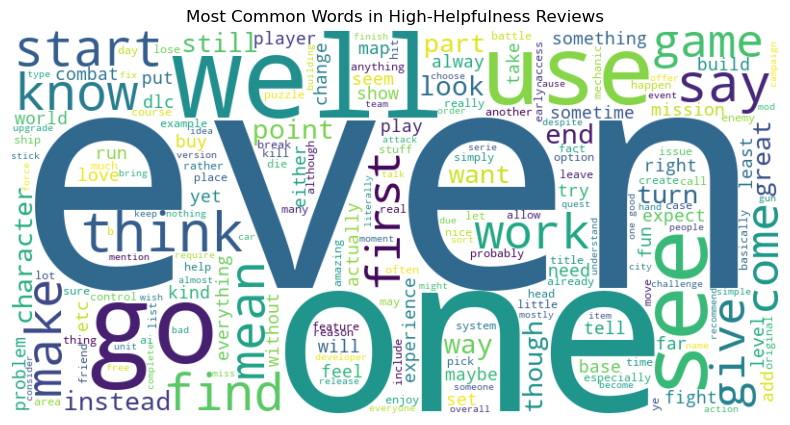

In [8]:
# 3. Word Cloud
print("Generating Word Cloud...")
all_text = " ".join(df['cleaned_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in High-Helpfulness Reviews')
plt.show()

Generating Frequency Plot...


C:\Users\beiyu\AppData\Local\Temp\ipykernel_17852\3365029400.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')


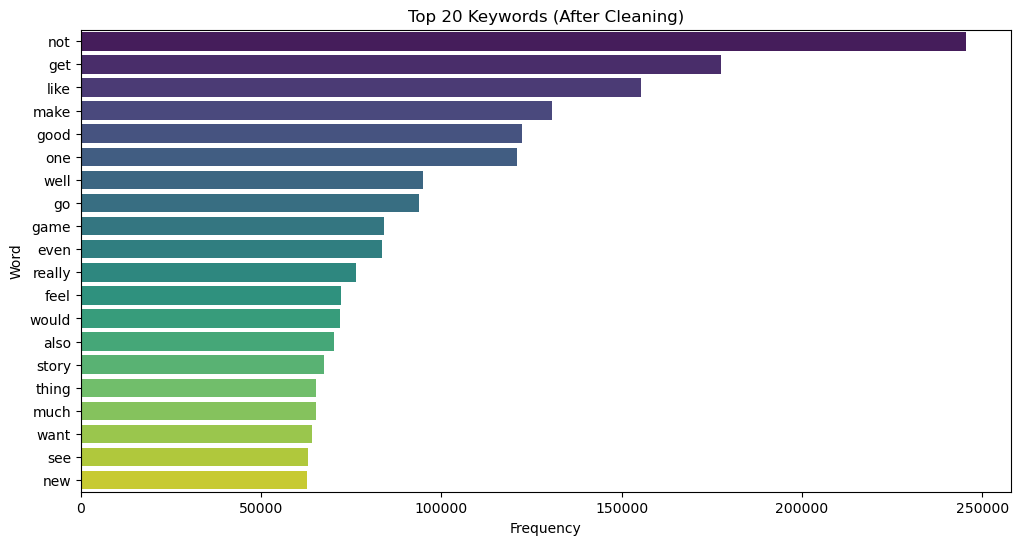

In [9]:
# 4. Keyword Frequency Plot
print("Generating Frequency Plot...")
# Split all cleaned reviews into a giant list of words
all_words = " ".join(df['cleaned_review']).split()
word_freq = Counter(all_words)

# Get top 20 words
common_words = word_freq.most_common(20)
words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')
plt.title('Top 20 Keywords (After Cleaning)')
plt.show()

Generating Correlation Heatmap...


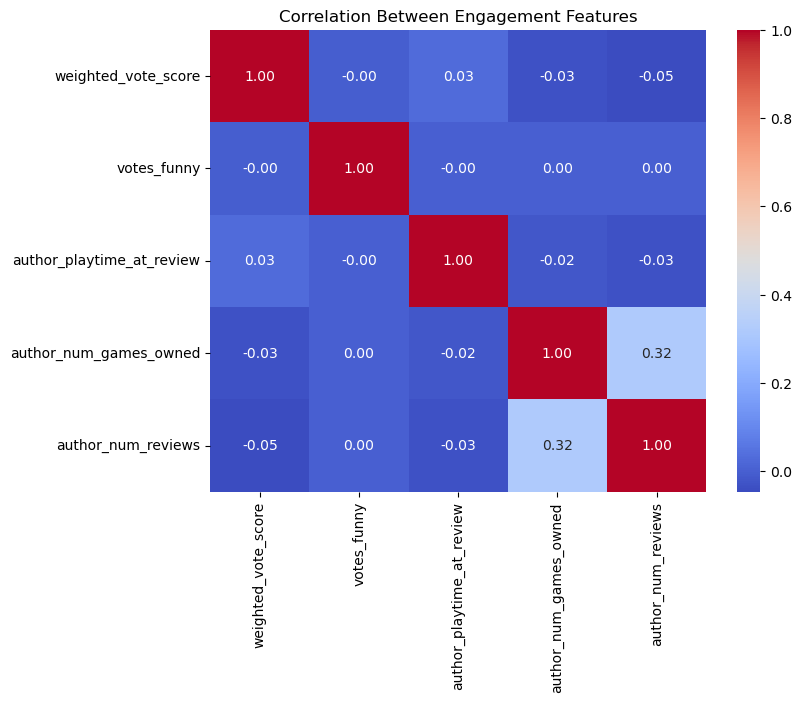

In [10]:
# 5. Correlation Heatmap
print("Generating Correlation Heatmap...")

# Select only numerical columns for correlation
numeric_cols = [
    'weighted_vote_score', 'votes_funny', 'author_playtime_at_review', 
    'author_num_games_owned', 'author_num_reviews'
]

categorical_cols = ['language', 'steam_purchase', 'received_for_free', 'written_during_early_access']

# Calculate correlation matrix
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Engagement Features')
plt.show()

,weighted_vote_score,votes_funny,author_playtime_at_review,author_num_games_owned,author_num_reviews
count,193166.000000,1.931660e+05,1.931660e+05,193166.000000,193166.000000
mean,0.858477,4.454213e+04,1.072348e+04,415.369480,49.129842
std,0.042107,1.382001e+07,6.006570e+04,1331.560964,153.630452
min,0.800000,0.000000e+00,0.000000e+00,0.000000,1.000000
25%,0.823212,3.000000e+00,1.180000e+02,0.000000,5.000000
50%,0.850720,1.100000e+01,6.420000e+02,48.000000,14.000000
75%,0.887437,4.900000e+01,2.909000e+03,330.000000,40.000000
max,0.995547,4.294967e+09,4.776595e+06,30425.000000,10413.000000


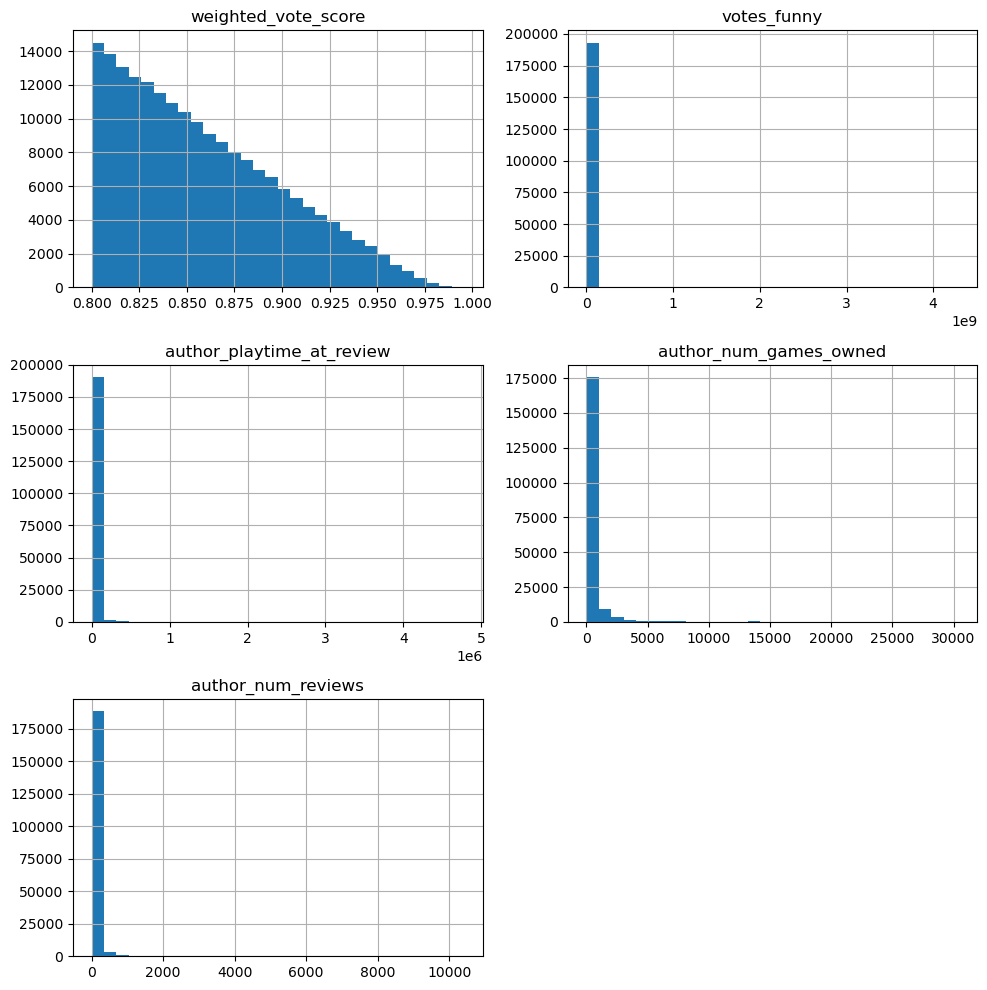

In [11]:
# Exploratory Analysis
display(df[numeric_cols].describe())
df[numeric_cols].hist(bins=30, figsize=(10,10))
plt.tight_layout()
plt.show()

In [12]:
# We can see that the features are all extremely right skewed with clear outliers
# Weighted_vote_score has a nice gradual right skew while every other feature has a clear tail with large outliers
# This shows a need for feature standardization

In [13]:
# 6. Save Output
# Save the dataset with the new 'cleaned_review' column
df.to_csv(OUTPUT_FILE, index=False)
print(f"Saved processed data to {OUTPUT_FILE}")

Saved processed data to ../../data/processed_text.csv


In [14]:
features = ['author_playtime_at_review', 'author_num_games_owned', 'author_num_reviews', 'votes_funny', 'weighted_vote_score']

target = 'voted_up'
df[target] = df[target].astype(int)

X = df[features]
y = df[target]

In [15]:
# imputer to handle missing data
imp = SimpleImputer(strategy='mean')
X_imp = imp.fit_transform(X)

# scale data for logistical regression
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_imp)

In [16]:
# train data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=0)

In [17]:
# initialize the simple models
knn = KNeighborsClassifier(n_neighbors=5)
logmodel = LogisticRegression(random_state=0)
decisiontree = DecisionTreeClassifier(random_state=0)

In [18]:
# train models
print("Training Logistic Regression Model:")
logmodel.fit(X_train, y_train)
y_pred_log = logmodel.predict(X_test)
print("Training Decision Tree Model:")
decisiontree.fit(X_train, y_train)
y_pred_dt = decisiontree.predict(X_test)
print("Training KNN:")
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

Training Logistic Regression Model:
Training Decision Tree Model:
Training KNN:


In [19]:
# display results
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log)}")
print(f"Precision: {precision_score(y_test, y_pred_log)}")
print(f"Recall: {recall_score(y_test, y_pred_log)}")
print(f"F1 Score: {f1_score(y_test, y_pred_log)}")
print("")
print("Decision Tree:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(f"Precision: {precision_score(y_test, y_pred_dt)}")
print(f"Recall: {recall_score(y_test, y_pred_dt)}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt)}")
print("")
print("KNN:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn)}")
print(f"Precision: {precision_score(y_test, y_pred_knn)}")
print(f"Recall: {recall_score(y_test, y_pred_knn)}")
print(f"F1 Score: {f1_score(y_test, y_pred_knn)}")

Logistic Regression:
Accuracy: 0.8100119066107574
Precision: 0.8100119066107574
Recall: 1.0
F1 Score: 0.8950348930328338

Decision Tree:
Accuracy: 0.709504581456748
Precision: 0.8276897959183673
Recall: 0.8099955262989711
F1 Score: 0.8187470727886432

KNN:
Accuracy: 0.7777864057565874
Precision: 0.8137729018708376
Recall: 0.941011056432543
F1 Score: 0.8727790044605148


array([[    0,  7340],
       [    0, 31294]])

array([[ 2063,  5277],
       [ 5946, 25348]])

array([[  601,  6739],
       [ 1846, 29448]])

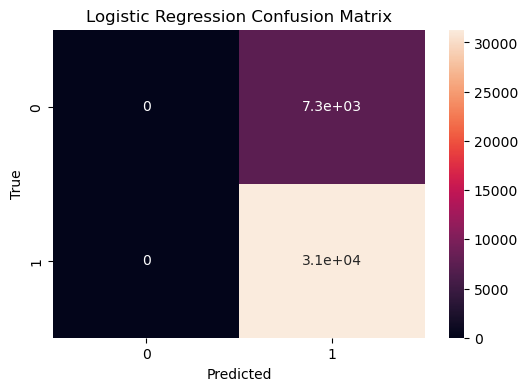

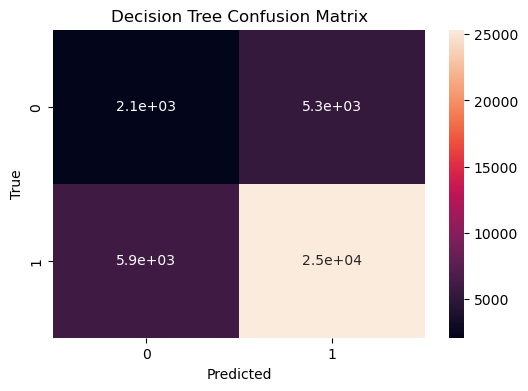

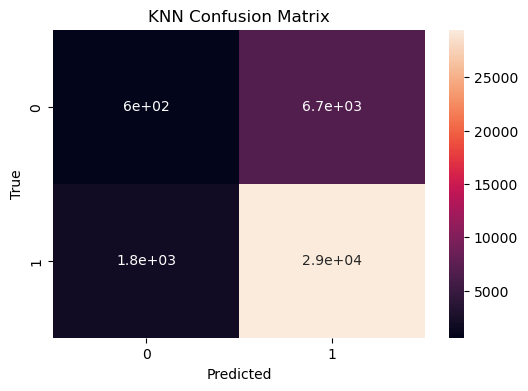

In [20]:
# Confusion Matrices for the simple models

# Logistic Regression
display(confusion_matrix(y_test, y_pred_log));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Logistic Regression Confusion Matrix');

# Decision Tree
display(confusion_matrix(y_test, y_pred_dt));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Decision Tree Confusion Matrix');

# KNN
display(confusion_matrix(y_test, y_pred_knn));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('KNN Confusion Matrix');

In [21]:
print(df['voted_up'].value_counts(normalize=True))
print("This shows that logistic regression just guessed 'positive' for all of the reviews.")

voted_up
1    0.807306
0    0.192694
Name: proportion, dtype: float64
This shows that logistic regression just guessed 'positive' for all of the reviews.


In [22]:
# the more advanced models
for col in ['steam_purchase', 'received_for_free', 'written_during_early_access']:
    if col in df.columns:
        df[col] = df[col].astype(int)

X_adv = df[numeric_cols + categorical_cols +  ['cleaned_review']]
y_adv = df['voted_up'].astype(int)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_adv, y_adv, test_size=0.2, random_state=0)

In [24]:
# numerical transformer
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
# converts text into numerical vectors
text_transformer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
# cat variables
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])
preproc = ColumnTransformer(transformers=[('num', numerical_transformer, numeric_cols), ('cat', categorical_transformer, categorical_cols), ('txt', text_transformer, 'cleaned_review')])

In [25]:
# random forest
print("Training Random Forest: ")
randomforest = Pipeline(steps=[('preprocessor', preproc), ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state = 0, n_jobs = 1))])
randomforest.fit(X_train, y_train)
y_pred_randomforest = randomforest.predict(X_test)
print("")
print("Random Forest: ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_randomforest)}")
print(f"Precision: {precision_score(y_test, y_pred_randomforest)}")
print(f"Recall:    {recall_score(y_test, y_pred_randomforest)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_randomforest)}")

Training Random Forest: 

Random Forest: 
Accuracy:  0.8711497644561785
Precision: 0.871589946342841
Recall:    0.9862273918323001
F1 Score:  0.9253717917965939


In [26]:
# gradient boosting

print("Training Gradient Boosting: ")
gradientboosting = Pipeline(steps=[('preprocessor', preproc), ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=0))])
gradientboosting.fit(X_train, y_train)
y_pred_gradientboosting = gradientboosting.predict(X_test)
print("")
print("Gradient Boosting: ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_gradientboosting)}")
print(f"Precision: {precision_score(y_test, y_pred_gradientboosting)}")
print(f"Recall:    {recall_score(y_test, y_pred_gradientboosting)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_gradientboosting)}")

Training Gradient Boosting: 

Gradient Boosting: 
Accuracy:  0.8537039913029973
Precision: 0.8548967502629685
Recall:    0.9868984469866428
F1 Score:  0.9161673094037378


In [27]:
# adaboost
adaboost = Pipeline(steps=[('preprocessor', preproc), ('classifier', AdaBoostClassifier(n_estimators=50, random_state=0))])
print("Training AdaBoost: ")
adaboost.fit(X_train, y_train)
y_pred_adaboost = adaboost.predict(X_test)
print("")
print("Ada Boosting: ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_adaboost)}")
print(f"Precision: {precision_score(y_test, y_pred_adaboost)}")
print(f"Recall:    {recall_score(y_test, y_pred_adaboost)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_adaboost)}")

Training AdaBoost: 

Ada Boosting: 
Accuracy:  0.8225138479059896
Precision: 0.8250897964613543
Recall:    0.9909567329200486
F1 Score:  0.9004486127847384


In [28]:
# support vector machine
svm_model = Pipeline(steps=[('preprocessor', preproc), ('classifier', LinearSVC(C=1.0, random_state=0, dual='auto'))])
print("Training Linear SVM: ")
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("")
print("Linear SVM: ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_svm)}")
print(f"Precision: {precision_score(y_test, y_pred_svm)}")
print(f"Recall:    {recall_score(y_test, y_pred_svm)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_svm)}")

Training Linear SVM: 

Linear SVM: 
Accuracy:  0.8970078169488016
Precision: 0.9163237311385459
Recall:    0.9605675209305298
F1 Score:  0.9379241485826612


In [29]:
# neural network
nn= Pipeline(steps=[('preprocessor', preproc), ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=0))])
print("Training Neural Network: ")
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
print("")
print("Neural Network: ")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_nn)}")
print(f"Precision: {precision_score(y_test, y_pred_nn)}")
print(f"Recall:    {recall_score(y_test, y_pred_nn)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_nn)}")

Training Neural Network: 

Neural Network: 
Accuracy:  0.8892167520836569
Precision: 0.9239751396823404
Recall:    0.9406275963443471
F1 Score:  0.9322270078540664


array([[ 2793,  4547],
       [  431, 30863]])

array([[ 2098,  5242],
       [  410, 30884]])

array([[  766,  6574],
       [  283, 31011]])

array([[ 4595,  2745],
       [ 1234, 30060]])

array([[ 4918,  2422],
       [ 1858, 29436]])

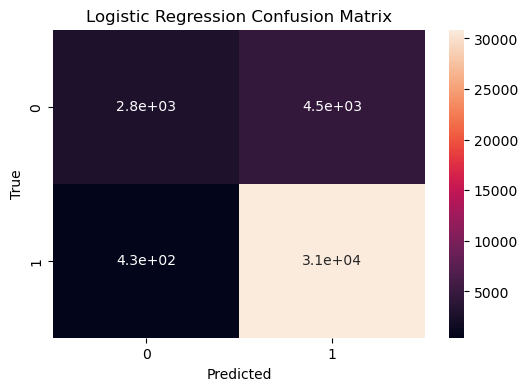

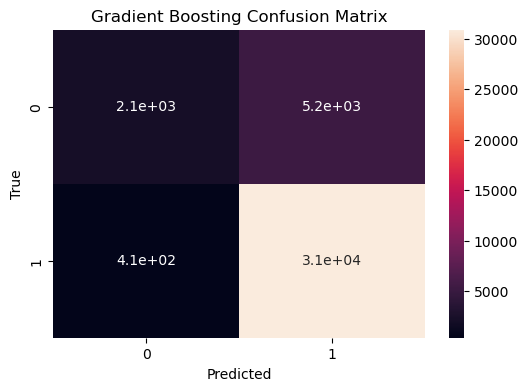

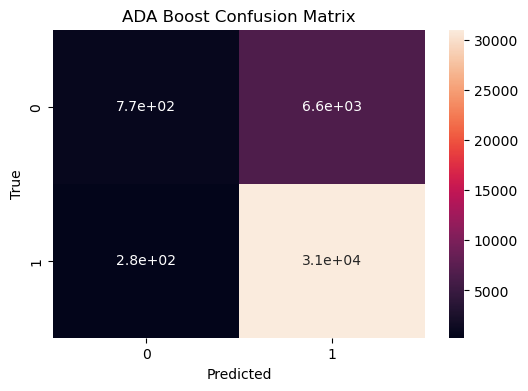

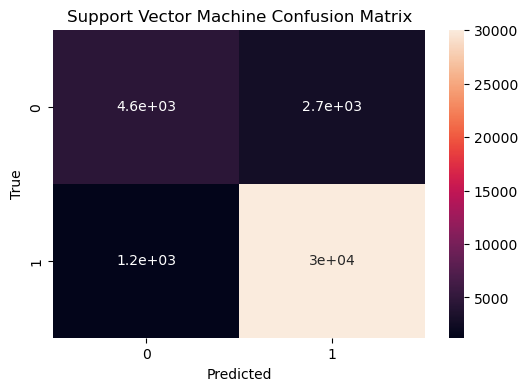

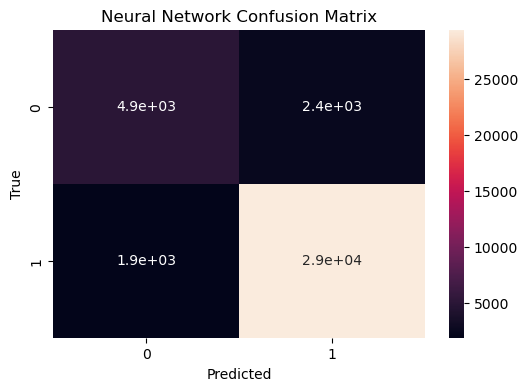

In [30]:
# Confusion Matrices for the complex models

# Random Forest
display(confusion_matrix(y_test, y_pred_randomforest));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_randomforest), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Logistic Regression Confusion Matrix');

# Gradient Boosting
display(confusion_matrix(y_test, y_pred_gradientboosting));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_gradientboosting), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Gradient Boosting Confusion Matrix');

# ADA Boost
display(confusion_matrix(y_test, y_pred_adaboost));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_adaboost), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('ADA Boost Confusion Matrix');

# Support Vector Machines
display(confusion_matrix(y_test, y_pred_svm));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Support Vector Machine Confusion Matrix');

# Neural Network
display(confusion_matrix(y_test, y_pred_nn));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Neural Network Confusion Matrix');

In [ ]:
# Ada Boost Optimization

ada_pipe = Pipeline(steps=[
    ("preprocessor", preproc),
    ("classifier", AdaBoostClassifier(random_state=0))
])

ada_param = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__learning_rate":[0.01, 0.1, 1.0]
}

ada_grid = GridSearchCV(
    ada_pipe,
    param_grid=ada_param,
    scoring="f1", 
    cv=3,
    n_jobs=-1
)

ada_grid.fit(X_train, y_train)

print("Best AdaBoost Parameters: ", ada_grid.best_params_)

ada_pred = ada_grid.best_estimator_.predict(X_test)
ada_prob = ada_grid.best_estimator_.predict_proba(X_test)[:, 1] # ROC

# SVM Optimization

svm_pipe = Pipeline(steps=[
    ("preprocessor", preproc),
    ("classifier", LinearSVC(dual="auto"))
])

svm_param = {
    "classifier__C": [0.01, 0.1, 1, 5]
}

svm_grid = GridSearchCV(
    svm_pipe, 
    param_grid=svm_param, 
    cv=3, 
    scoring="f1", 
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)

print("Best SVM Parameters: ", svm_grid.best_params_)

svm_pred = svm_grid.best_estimator_.predict(X_test)
svm_prob = svm_grid.best_estimator_.decision_function(X_test)

# Neural Network Optimization

nn_pipe = Pipeline(steps=[
    ("preprocessor", preproc),
    ("classifier", MLPClassifier(max_iter=300, random_state=0))
])

nn_param = {
    "classifier__hidden_layer_sizes": [(50,), (100,), (100, 50)],
    "classifier__alpha": [0.001, 0.01, 0.1],
    "classifier__learning_rate_init": [0.001, 0.01]
}

nn_grid = GridSearchCV(
    nn_pipe, 
    param_grid=nn_param,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

nn_grid.fit(X_train, y_train)

print("Best NN Parameters: ", nn_grid.best_params_)

nn_pred = nn_grid.best_estimator_.predict(X_test)
nn_prob = nn_grid.best_estimator_.predict_proba(X_test)[:,1]

# Precision, Recall, F1

def display_prf(name, y_t, y_pred):
    print(name)
    print(f"Precision: {precision_score(y_t, y_pred)}")
    print(f"Recall: {recall_score(y_t, y_pred)}")
    print(f"F1 Score: {f1_score(y_t, y_pred)}")

display_prf("AdaBoost: ", y_test, ada_pred)
display_prf("Linear SVM: ", y_test, svm_pred)
display_prf("Neural Network", y_test, nn_pred)

# ROC Curves

plt.figure(figsize=(10, 8))

# Adaboost ROC
ada_f, ada_t, _ =  roc_curve(y_test, ada_prob)
ada_auc = roc_auc_score(y_test, ada_prob)
plt.plot(ada_f, ada_t, label=f"AdaBoost (AUC={ada_auc})")

# svm ROC
svm_f, svm_t, _ = roc_curve(y_test, svm_prob)
svm_auc = roc_auc_score(y_test, svm_prob)
plt.plot(svm_f, svm_t, label=f"Linear SVM (AUC={svm_auc})")

# nn ROC
nn_f, nn_t, _ = roc_curve(y_test, nn_prob)
nn_auc = roc_auc_score(y_test, nn_prob)
plt.plot(nn_f, nn_t, label=f"Neural Network (AUC={nn_auc})")

plt.title("Optimized Models ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print("\nAUC Scores: ")
print(f"AdaBoost AUC: {ada_auc}")
print(f"SVM AUC: {svm_auc}")
print(f"NN AUC: {nn_auc}")